In [5]:


import os
#**
import gc
import time
import numpy as np
import pandas as pd
#**
from contextlib import contextmanager

import multiprocessing as mp
#**
from functools import partial

#**
from scipy.stats import kurtosis, iqr, skew
#**
from lightgbm import LGBMClassifier
#**
from sklearn.linear_model import LinearRegression
#**
from sklearn.model_selection import KFold, StratifiedKFold
#**
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore' ,category=FutureWarning)


In [6]:
# debug 할 때는 적은 Row를 사용할 수 있도록

debug =True
num_rows = 30000 if debug else None

In [9]:
NUM_THREADS = 4
DATA_DIRECTORY = './home-credit-default-risk/'
SUBMISSION_SUFIX = "_model2_04"

In [12]:
path = DATA_DIRECTORY
num_rows=num_rows

train= pd.read_csv(os.path.join(path,'application_train.csv'), nrows=num_rows)
test = pd.read_csv(os.path.join(path, 'application_test.csv'),nrows=num_rows)
os.path.join(path, 'application_train.csv')

'./home-credit-default-risk/application_train.csv'

In [15]:
# imbalance 한 지 확인  -> oversampling or undersampling
train['TARGET'].value_counts()

0    27597
1     2403
Name: TARGET, dtype: int64

In [16]:
# == train.append(test)
df =  pd.concat([train,test])

In [18]:
del train, test

In [19]:
# garbage colletor 메모리 남아있는 것 줍줍
gc.collect()

9974

In [21]:
# preprocessing
# missing value check debug false 일 때
#df['CODE_GENDER'].value_counts() 4개 밖에 없으므로 outlier 취급하여 제거
df[df['CODE_GENDER'] != 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,318261,NaN,Cash loans,F,N,Y,0,126000.0,148500.0,15345.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
29996,318263,NaN,Cash loans,F,N,Y,0,135000.0,601470.0,30838.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
29997,318264,NaN,Cash loans,F,N,N,0,130500.0,260640.0,31059.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
29998,318266,NaN,Cash loans,F,N,N,0,202500.0,522396.0,38142.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [ ]:
#
#MAX INCOME in test is 4M; train has a 117M value 200만이상은 그냥 자른다
df = df[df['AMT_INCOME_TOTAL'] < 2000000]

In [24]:
# 근무일수 이상치 치환
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan , inplace=True)

In [31]:
# Flag_documnet features - count and kurtosis
docs = [f for f in df.columns if 'FLAG_DOC' in f]

In [32]:
#
#kurtosis : 통계적 요소
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

<AxesSubplot:>

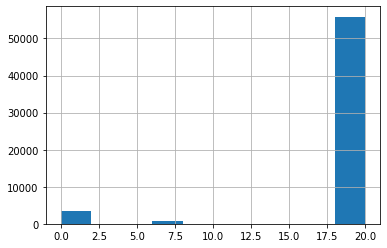

In [33]:
df[docs].kurtosis(axis=1).hist()

In [34]:
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)


In [ ]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

In [220]:
df = df
categorical_columns = None

In [284]:
BUREAU_ACTIVE_AGG

NameError: name 'BUREAU_ACTIVE_AGG' is not defined

In [ ]:
if not categorical_columns:
    categorical_columns = [col for col in df.columns if df[col].dtype =='object']

In [304]:
# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}



In [313]:
bureau2 = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)


In [315]:
bureau2['AMT_CREDIT_SUM_DEBT']

0             0.0
1        171342.0
2             NaN
3             NaN
4             NaN
           ...   
29995         NaN
29996         NaN
29997         NaN
29998     70389.0
29999         NaN
Name: AMT_CREDIT_SUM_DEBT, Length: 30000, dtype: float64

In [ ]:
def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau

In [317]:
bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
# Credit duration and credit/account end date difference
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
# Credit to debt ratio and difference
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

# One-hot encoder
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
# Join bureau balance features
bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
# Flag months with late payments (days past due)
bureau['STATUS_12345'] = 0
for i in range(1,6):
    bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

# Aggregate by number of months in balance and merge with bureau (loan length agg)
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
del agg_length; gc.collect()

In [ ]:
# General loans aggregations
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
# Active and closed loans aggregations

In [319]:
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]


In [323]:

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

In [324]:
BUREAU_ACTIVE_AGG

{'DAYS_CREDIT': ['max', 'mean'],
 'DAYS_CREDIT_ENDDATE': ['min', 'max'],
 'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
 'AMT_CREDIT_SUM': ['max', 'sum'],
 'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
 'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
 'DAYS_CREDIT_UPDATE': ['min', 'mean'],
 'DEBT_PERCENTAGE': ['mean'],
 'DEBT_CREDIT_DIFF': ['mean'],
 'CREDIT_TO_ANNUITY_RATIO': ['mean'],
 'MONTHS_BALANCE_MEAN': ['mean', 'var'],
 'MONTHS_BALANCE_SIZE': ['mean', 'sum']}

In [325]:
agg_bureau = group_and_merge(active , agg_bureau, 'BUREAU_ACTIVE_', BUREAU_ACTIVE_AGG)

In [326]:
agg_bureau


,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,...,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_VAR,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_SUM
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,...,0.0,-1945.0,-1945.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,...,0.0,-1857.0,-929.000000,10.671515,1101145.500,14.925373,NaN,NaN,NaN,0.0
2,100320,5,-2410,-865,-1589.000000,-1400.0,598.0,540.000,108.000,1739394.0,...,0.0,-686.0,-669.000000,11.249851,652802.535,NaN,NaN,NaN,NaN,0.0
3,100430,1,-115,-115,-115.000000,31084.0,31084.0,NaN,NaN,67500.0,...,0.0,-6.0,-6.000000,1.079603,4977.000,NaN,NaN,NaN,NaN,0.0
4,100568,7,-1274,-207,-493.857143,-969.0,1183.0,8178.885,8178.885,333000.0,...,0.0,-189.0,-76.333333,2.419985,45133.500,22.402971,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,456114,6,-2795,-15,-1496.500000,-1699.0,1.0,NaN,NaN,289170.0,...,0.0,-1333.0,-676.500000,0.966520,-7794.000,14.092446,NaN,NaN,NaN,0.0
6072,456116,2,-1812,-941,-1376.500000,-1264.0,-759.0,0.000,0.000,73642.5,...,0.0,-1292.0,-1292.000000,14.380492,68521.500,13.856901,NaN,NaN,NaN,0.0
6073,456179,4,-993,-684,-854.250000,-811.0,273.0,0.000,0.000,135000.0,...,0.0,-13.0,-13.000000,1.425555,40300.065,NaN,NaN,NaN,NaN,0.0
6074,456181,3,-599,-101,-420.666667,82.0,1264.0,0.000,0.000,202500.0,...,0.0,-56.0,-56.000000,1.202920,27877.500,NaN,NaN,NaN,NaN,0.0


In [327]:

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

In [331]:
BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

In [328]:
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
del active, closed; gc.collect()

51883

In [332]:
# 그룹을 잘 그룹화시키기 ,

# Aggregation for the main loan types
for credit_type in ['Consumer credit', 'Credit card' , 'Mortgage', 'Car loan', 'Microloan']:

    type_df =  bureau[bureau['CREDIT_TYPE_'+ credit_type]== 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() +'_'
    agg_bureau = group_and_merge(type_df , agg_bureau,prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [334]:


#Time based aggregations: last x months

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,MONTHS_BALANCE_SIZE,STATUS_12345,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,245832,5800005,-245,0,-232.0,-188.0,NaN,0,31500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29996,245832,5800006,-287,0,-274.0,-188.0,NaN,0,45000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29997,245832,5800008,-175,0,-162.0,NaN,NaN,0,31090.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29998,245832,5800009,-158,0,1387.0,NaN,NaN,0,67500.0,70389.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# permutation feature importance 에서 feture permutation 조합의 중요도가 낮은 것은 버린다
def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df


In [ ]:
def get_age_label(days_birth):
    """ Return the age gorup label (int)."""
    age_years = -days_birth /365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years <50: return 3
    elif age_years <65: return 4
    elif age_years < 99: return 5
    else : return 0

In [35]:
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x:get_age_label(x))

In [38]:
# 태어난 날짜를 가지고 나이계산
df['DAYS_BIRTH']

0        -9461
1       -16765
2       -19046
3       -19005
4       -19932
         ...  
29995   -21635
29996   -17958
29997   -19958
29998   -10183
29999   -17069
Name: DAYS_BIRTH, Length: 60000, dtype: int64

In [41]:
# feature importance top . 비식별화 되어서 무엇인지는 모른다 사람들이
# 그러니 feature importance를 탐색을 해야하
#

# New features based on Extenal sources
df['EXT_SOURCES_PROD']= df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']



In [43]:
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3#%%



In [44]:
np.warnings.filterwarnings('ignore', r'ALL-NaN (slice|axis) encountered')

In [46]:
# eval은 string을 함수처럼 사용할 수 있도록 ?
for function_name in ['min','max','mean','nanmedian','var','max']:
    feature_name= 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']],axis=1)

In [49]:
# 1년 동안 annutity(연금) 과 credit의 비율로 신용도확인하기위함

KeyError: 'AMT_ANNUTIY'

In [51]:
# credit ratio
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
# Income ratios
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

In [154]:
# Time ratios
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [53]:
from collections import deque
# Groupby Statistics for applications in the same group

ModuleNotFoundError: No module named 'deque'

In [206]:
# Groupby: Statistics for applications in the same group
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']

In [218]:
# 이름을 변경할 때 사전과함께 사용 중단

#https://stackoverflow.com/questions/60229375/solution-for-specificationerror-nested-renamer-is-not-supported-while-agg-alo
df[group_cols+[counted]].groupby(group_cols)[counted].agg(max='max')

max
ORGANIZATION_TYPE NAME_EDUCATION_TYPE           OCCUPATION_TYPE      AGE_RANGE CODE_GENDER          
Advertising       Higher education              Accountants          2         F            0.633830
                                                                     3         F            0.624797
                                                Cleaning staff       4         F            0.499534
                                                Core staff           1         F            0.626520
                                                                     2         F            0.663931
...                                                                                              ...
University        Secondary / secondary special Medicine staff       4         F            0.632774
                                                Security staff       3         F            0.679975
                                                                     4         F            0.649977
                                                Waiters/barmen staff 3         F            0.576553
                                                                     4         F            0.382108

[4727 rows x 1 columns]

In [ ]:
df = do_mean(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')

In [209]:
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')

In [210]:
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')

In [211]:
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [230]:
df = drop_application_columns(df )

In [233]:
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # nan value 를 남기는 NAN_as_Category lgbm은 nan 데이터를 무시하고 학습하고 null을 활용함 lgbm은
    # get_dummy encoding
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns

In [262]:
def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
29995,5230723,-24,0,0,0,0,0,0,1,0
29996,5230723,-25,0,0,0,0,0,0,1,0
29997,5230723,-26,0,0,0,0,0,0,1,0
29998,5230723,-27,0,0,0,0,0,0,1,0


In [ ]:
bb

In [ ]:
bb.groupby('SK_ID').agg(agg)

In [ ]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [ ]:
groups = group

In [273]:
del group

In [274]:
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [339]:

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

In [340]:
# Time_based aggregation

# Time based aggregations: last x months
# 최근 6달 혹은 12개월 안쪽의 데이터 추출
for time_frame in [6, 12]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

In [ ]:
# last loan max overdue
# 가장 최근 최대 대출 기한 feature 들을 뽑아내는 능력
sort_bureau = bureau.sort_values(by='DAYS_CREDIT')

In [ ]:
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()

In [349]:
sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last()

SK_ID_CURR
100053          NaN
100312          NaN
100320        0.000
100430          NaN
100568     8178.885
            ...    
456114          NaN
456116        0.000
456179        0.000
456181        0.000
456247    15997.410
Name: AMT_CREDIT_MAX_OVERDUE, Length: 6076, dtype: float64

In [ ]:
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)

agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

In [348]:
agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']

In [292]:
bureau['STATUS_12345'] = 0
for i in range(1,6):
    bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,245832,5800005,-245,0,-232.0,-188.0,NaN,0,31500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29996,245832,5800006,-287,0,-274.0,-188.0,NaN,0,45000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29997,245832,5800008,-175,0,-162.0,NaN,NaN,0,31090.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29998,245832,5800009,-158,0,1387.0,NaN,NaN,0,67500.0,70389.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [294]:
# Aggregate by number of months in balance and merge with bureau (loan length agg)
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']

In [295]:

bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
# Credit to debt ratio and difference
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']


KeyError: "Columns not found: 'DEBT_CREDIT_DIFF', 'DEBT_PERCENTAGE'"

In [311]:
agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()

KeyError: "Columns not found: 'AMT_CREDIT_SUM_DEBT', 'STATUS_0', 'AMT_CREDIT_SUM', 'AMT_CREDIT_MAX_OVERDUE', 'STATUS_12345', 'AMT_CREDIT_SUM_OVERDUE', 'DEBT_CREDIT_DIFF', 'DEBT_PERCENTAGE'"

In [312]:
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)

KeyError: "Column(s) ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE', 'DEBT_CREDIT_DIFF', 'LL_AMT_CREDIT_SUM_OVERDUE', 'LL_DEBT_CREDIT_DIFF', 'LL_STATUS_12345', 'STATUS_0', 'STATUS_12345'] do not exist"

NameError: name 'agg_length' is not defined

In [ ]:
agg_length.rename({feat: 'LL_'+feat for feat in features}, axis=1, inplace=True)

In [307]:
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')

NameError: name 'agg_length' is not defined

In [ ]:
bureau = bureau.merge(agg_length, how='left' , on='MONTHS_BALANCE_SIZE')
del agg_length; gc.collect()

In [305]:
BUREAU_AGG

{'SK_ID_BUREAU': ['nunique'],
 'DAYS_CREDIT': ['min', 'max', 'mean'],
 'DAYS_CREDIT_ENDDATE': ['min', 'max'],
 'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
 'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
 'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
 'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
 'AMT_ANNUITY': ['mean'],
 'DEBT_CREDIT_DIFF': ['mean', 'sum'],
 'MONTHS_BALANCE_MEAN': ['mean', 'var'],
 'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_12345': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean'],
 'CREDIT_ACTIVE_Active': ['mean'],
 'CREDIT_ACTIVE_Closed': ['mean'],
 'CREDIT_ACTIVE_Sold': ['mean'],
 'CREDIT_TYPE_Consumer credit': ['mean'],
 'CREDIT_TYPE_Credit card': ['mean'],
 'CREDIT_TYPE_Car loan': ['mean'],
 'CREDIT_TYPE_Mortgage': ['mean'],
 'CREDIT_TYPE_Microloan': ['mean'],
 'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
 'LL_DEBT_CREDIT_DIFF': ['mean'],
 'LL_STATUS_12345': ['mean']}

In [306]:
# General loans aggregations
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)

KeyError: "Column(s) ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE', 'DEBT_CREDIT_DIFF', 'LL_AMT_CREDIT_SUM_OVERDUE', 'LL_DEBT_CREDIT_DIFF', 'LL_STATUS_12345', 'STATUS_0', 'STATUS_12345'] do not exist"

In [ ]:
# Active and closed losan aggregations

In [ ]:
# 특정 카테고리를 기준으로 Groupby를 해보면서 타겟 값에 대한 평균을 낸다던지 어떤 그룹은 상환을 잘한다 그런걸 찾는다

In [ ]:
#
agg_df = bb.groupby('SK_ID_BUREAU').agg(agg)

In [290]:
# multiindex to list
#pd.Index(['{}{}_{}'.format(prefix , e[0])])
#agg_df.columns.tolist()
# feature 자체가 정말 의미있어보이든 없든 모델이 학습할만하다면 넣어준다

[('MONTHS_BALANCE', 'min'),
 ('STATUS_0', 'min'),
 ('STATUS_1', 'min'),
 ('STATUS_2', 'min'),
 ('STATUS_3', 'min'),
 ('STATUS_4', 'min'),
 ('STATUS_5', 'min'),
 ('STATUS_C', 'min'),
 ('STATUS_X', 'min')]

In [ ]:
group_and_merge()
#agg =  ['min', 'max', 'mean', 'size']
# pandas version up and cant' use list agg -> no can use
agg= 'min'



In [278]:
bureau = bureau.merge(get_bureau_balance(path,num_rows), how='left', on='SK_ID_BUREAU')


In [ ]:
bureau['STATUS_12345']

In [ ]:
bureau_df = get_bureau()

In [216]:
df , group_cols , counted , agg_name = df, group , 'EXT_SOURCES_MEAN' ,'GROUP_EXT_SOURCES_MEDIAN'

In [161]:
group_cols +[counted]

['ORGANIZATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'OCCUPATION_TYPE',
 'AGE_RANGE',
 'CODE_GENDER',
 'EXT_SOURCES_MEAN']

In [212]:
gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(columns={ counted : agg_name})

TypeError: unsupported operand type(s) for +: 'function' and 'list'

In [169]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.158397,0.121978,2.007889,-317.896389,-21.403657,0.067329,0.224078,NaN,NaN,0.119860
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.145199,0.132217,4.790750,-227.272727,-16.104981,0.070862,0.017358,NaN,NaN,0.049389
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.000000,0.100000,2.000000,-300.000000,-3.544051,0.011814,0.132889,-0.001365,-0.115556,0.042791
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,1.052803,0.219900,2.316167,-44.422507,-7.103394,0.159905,0.128229,NaN,NaN,0.032465
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.000000,0.179963,4.222222,-39.993417,-6.095725,0.152418,0.173490,NaN,NaN,0.055489


In [170]:
df = df.merge(gp, on=group_cols, how='left')

In [171]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.121978,2.007889,-317.896389,-21.403657,0.067329,0.224078,NaN,NaN,0.119860,0.378817
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.132217,4.790750,-227.272727,-16.104981,0.070862,0.017358,NaN,NaN,0.049389,0.572513
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.100000,2.000000,-300.000000,-3.544051,0.011814,0.132889,-0.001365,-0.115556,0.042791,0.602979
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.219900,2.316167,-44.422507,-7.103394,0.159905,0.128229,NaN,NaN,0.032465,0.577263
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.179963,4.222222,-39.993417,-6.095725,0.152418,0.173490,NaN,NaN,0.055489,0.322738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,318261,NaN,Cash loans,F,N,Y,0,126000.0,148500.0,15345.0,...,0.121786,1.178571,NaN,-5.823896,NaN,0.214514,NaN,NaN,0.086342,NaN
59996,318263,NaN,Cash loans,F,N,Y,0,135000.0,601470.0,30838.5,...,0.228433,4.455333,-51.097653,-7.517541,0.147121,0.084586,NaN,NaN,0.090545,NaN
59997,318264,NaN,Cash loans,F,N,N,0,130500.0,260640.0,31059.0,...,0.238000,1.997241,-149.827784,-6.538731,0.043642,0.176420,NaN,NaN,0.059074,0.598611
59998,318266,NaN,Cash loans,F,N,N,0,202500.0,522396.0,38142.0,...,0.188356,2.579733,-103.580563,-19.886085,0.191987,0.280271,NaN,NaN,0.159678,0.455738


In [ ]:
gp.head()

In [ ]:
df[group_cols]

In [200]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(\
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [ ]:
from collections import deque


In [196]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [97]:
')

In [ ]:
#truck_weights.pop(0)

In [98]:
#sum(truck_weights)

deque2 = deque([0,0,0])

In [147]:
deque2.append(1)

In [148]:
deque2.rotate(-1)

In [150]:
deque2.pop()

In [152]:
deque2

0

In [153]:
on_bridge.append(3)

deque([0, 0, 1])

In [ ]:
#truck_weights


on_bridge = deque()

In [122]:



sum(on_bridge)

7

In [145]:
bridge_length= 10

In [146]:
deque([0] * bridge_length,maxlen=bridge_length)

deque([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [123]:
# 아직 다리에 오르지 않은 트럭이 있다면
# 트럭을 무조건 빼면 안된다
            #truck = truck_weights.pop(0)
# 트럭이 들어가면 무게가 초과된다면 ,다리에 있는 트럭 중 하나를 빼고(x)
            # 트럭에 있는 다리들을 왼쪽으로 한 칸씩 이동시키고 트럭이 내릴 순서가 되면 내리고 시간을 늘린다.
            # 무게가 넘지 않는다면 트럭을 다리로 이동 시키고 원래 있던 트럭은 완료시키며(x)
            # 다리의 길이가 2기 때문에 한칸씩 왼쪽으로 옮긴다 원시간은 지난다
# 가장 처음 타임에는 옮기지 않는다 (x)->
# 무게를 검사한 뒤 트럭을 옮긴다
# 그래도 너무 하드코딩되네
# 다른 사람 풀이 https://this-programmer.tistory.com/entry/%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%A8%B8%EC%8A%A4Level2%ED%8C%8C%EC%9D%B4%EC%8D%AC3python3-%EB%8B%A4%EB%A6%AC%EB%A5%BC-%EC%A7%80%EB%82%98%EB%8A%94-%ED%8A%B8%EB%9F%AD
# 근데 이사람도 끔찍한 시도를 했다 . 나도 잠깐 했지만 트럭이 머문시간을 dict 에 저장하는건 너무 하드하다

def solution(bridge_length, weight, truck_weights):

    #on_bridge = deque([0] * bridge_length,maxlen=bridge_length)
    #complete_truck = []
    answer = 0
    on_bridge = [0] * bridge_length
    #complete_len = len(truck_weights)
    #다리에 더할 필요 없이 어차피 다리에 더하는 시점이 끝나면 brige는 모두 빼야한다 -> 이 포인트를 잘못 잡았다
    # 줄여 나가는 건 다리로 충분
    # 이걸 잘못 잡았다
    #while truck_weights or on_bridge:
    # 또 complete truck 을 잡을 필요도 없었다
    # 불필요하거나 잘못 짚는 포인트가 많다
# 다른 사람 풀이보고 얼추 맞춘 코드.

    while len(on_bridge):
        answer += 1
        on_bridge.popleft()
        if truck_weights:
            on_bridge_weight = sum(on_bridge) + truck_weights[0]
            if on_bridge_weight > weight:
                #on_bridge.rotate(-1)
                #if on_bridge[0] != 0:
                on_bridge.append(0)
            else:
                on_bridge.append(truck_weights.pop(0))
        return answer
        #         on_bridge.rotate(-1)
        #
        #         if on_bridge[0] != 0:
        #             complete_truck.append(on_bridge.popleft())
        # else:
        #
        #     on_bridge.rotate(-1)
        #     if on_bridge[0] != 0:
        #         complete_truck.append(on_bridge.popleft())
        #
        #         if len(complete_truck) == complete_len:
        #
        #

    return answer

In [110]:
#assert solution(bridge_length,weight,truck_weights)

In [111]:

bridge_length = 2
weight = 10
truck_weights= [7,4,5,6]
solution(bridge_length,weight,truck_weights)

4

In [350]:

prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

In [352]:
# One-hot encode most important categorical features
ohe_columns = [
    'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']

In [353]:
prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

In [354]:
# Feature engineering: ratios and difference
prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
# Interest ratio on previous application (simplified)
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']



In [357]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved']==1]

In [392]:
active_df = approved[approved['DAYS_LAST_DUE'] ==365243]


In [396]:

pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]


active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]

In [ ]:
active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
active_pay_agg

In [366]:
active_pay_agg.reset_index(inplace=True)

In [394]:
active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] -active_pay_agg['AMT_PAYMENT']

NameError: name 'active_pay_agg' is not defined

In [376]:
active_df = active_df.merge(active_pay_agg, on='SK_ID_PREV',how='left')

In [377]:
active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT']- active_df['AMT_PAYMENT']

In [378]:
active_df['REPAYMENT_RATIO']= active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']

In [381]:
PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

In [393]:
# Perform aggregations for active applications
active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                         active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
del active_pay, active_pay_agg, active_df; gc.collect()

KeyError: "Column(s) ['AMT_PAYMENT', 'INSTALMENT_PAYMENT_DIFF', 'REMAINING_DEBT', 'REPAYMENT_RATIO'] do not exist"

In [ ]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan,inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243,np.nan,inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replcae(365243, np.nan, inplace=True)

In [ ]:
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)

In [ ]:
prev['DAYS_TERMINATION'].replace(365243,np.nan, inplace=True)

In [403]:


# Days last due difference (scheduled x done)
prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

/var/folders/c6/2j22b1rd02778st12c0mcr3w0000gn/T/ipykernel_71814/983118302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']


In [ ]:
prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] -prev['DAYS_LAST_DUE']

In [384]:
PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

In [388]:


PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

In [ ]:
categorical_agg = {key: ['mean'] for key in categorical_cols}

In [390]:
active_agg_df

NameError: name 'active_agg_df' is not defined

In [ ]:
#Perform general aggregatinos
agg_prev =  group(prev, 'PREV_' , {**PREVIOUS_AGG, **categorical_agg})
# Merge active loans dataframe on ag_prev
agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
del active_agg_df
; gc.collect

In [404]:
# Aggregations for approved and refused loans
agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)

In [408]:
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,APPLICATION_CREDIT_DIFF,APPLICATION_CREDIT_RATIO,CREDIT_TO_ANNUITY_RATIO,DOWN_PAYMENT_TO_CREDIT,SIMPLE_INTERESTS,DAYS_LAST_DUE_DIFF
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,...,0,0,1,0,-66555.0,0.835282,12.656622,NaN,0.037343,NaN
19,1173070,199178,4666.500,45000.0,49455.0,NaN,45000.0,SATURDAY,16,Y,...,0,0,1,0,-4455.0,0.909918,10.597878,NaN,0.038803,NaN
20,1506815,166490,25454.025,450000.0,491580.0,NaN,450000.0,MONDAY,6,Y,...,0,0,1,0,-41580.0,0.915416,19.312466,NaN,0.010113,NaN
22,1172842,302212,NaN,0.0,0.0,NaN,NaN,TUESDAY,9,Y,...,0,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN
23,1172937,302212,39475.305,1129500.0,1277104.5,NaN,1129500.0,THURSDAY,5,Y,...,0,0,1,0,-147604.5,0.884423,32.351986,NaN,0.012391,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29981,2828876,251800,2250.000,45000.0,45000.0,NaN,45000.0,MONDAY,13,Y,...,1,0,0,0,0.0,1.000000,20.000000,NaN,-inf,NaN
29982,2013467,259882,2250.000,45000.0,45000.0,NaN,45000.0,FRIDAY,11,Y,...,0,1,0,0,0.0,1.000000,20.000000,NaN,-inf,NaN
29986,1878361,214130,27449.820,450000.0,491580.0,NaN,450000.0,THURSDAY,12,Y,...,0,0,1,0,-41580.0,0.915416,17.908314,NaN,0.014173,NaN
29995,2006765,402412,19435.455,99832.5,105102.0,0.0,99832.5,TUESDAY,12,Y,...,0,0,1,0,-5269.5,0.949863,5.407746,0.000000,0.018253,NaN


In [ ]:
app_prev = group_and_merge(approved, agg_prev , 'APPROVED_', PREVIOUS_APPROVED_AGG)

del approved , refused ; gc.collect()

In [ ]:
# Aggregations for Consumer loans and Cash loans

In [ ]:

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT':
['mean'],
}

In [ ]:
for loan_type in ['Consumer loans', 'Cash loans']:
    type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
    prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
    agg_prev = group_and_merge(type_df, agg_prev
                               , prefix , PREVIOUS_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [415]:
#Get the SK_ID_PREV for loans with late payments (days past due)
pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x> 0 else 0)
dpd_id = prev[pay['LATE_PAYMENT'] >0]['SK_ID_PREV'].unique()

In [416]:
# Aggregations for loans with late payments
# -30 mean day count -30 * time_frame means recent 1 year
for time_frame in [12,24]:
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30 * time_frame]

    prefix = 'PREV_LAST{}M_'.format(time_frame)
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
del prev;gc.collect()
return agg_prev

array([1784265, 1173070, 2138466, ..., 2672876, 1099505, 1353153])

In [419]:
pos = pd.read_csv(os.path.join(path,'POS_CASH_balance.csv'),nrows=num_rows)

In [421]:
pos, categorical_cols = one_hot_encoder(pos,nan_as_category =False)

In [422]:
pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x : 1 if x >0 else 0)

0        0
1        0
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    0
29998    0
29999    1
Name: LATE_PAYMENT, Length: 30000, dtype: int64

In [ ]:
pos['LATE_PAYMENT']

In [424]:
categorical_agg = {key : ['mean'] for key in categorical_cols}

In [425]:
categorical_agg

{'NAME_CONTRACT_STATUS_Active': ['mean'],
 'NAME_CONTRACT_STATUS_Approved': ['mean'],
 'NAME_CONTRACT_STATUS_Completed': ['mean'],
 'NAME_CONTRACT_STATUS_Demand': ['mean'],
 'NAME_CONTRACT_STATUS_Returned to the store': ['mean'],
 'NAME_CONTRACT_STATUS_Signed': ['mean']}

In [426]:

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

In [432]:
categorical_agg


{'NAME_CONTRACT_STATUS_Active': ['mean'],
 'NAME_CONTRACT_STATUS_Approved': ['mean'],
 'NAME_CONTRACT_STATUS_Completed': ['mean'],
 'NAME_CONTRACT_STATUS_Demand': ['mean'],
 'NAME_CONTRACT_STATUS_Returned to the store': ['mean'],
 'NAME_CONTRACT_STATUS_Signed': ['mean']}

In [433]:
{**POS_CASH_AGG, **categorical_agg}

{'SK_ID_PREV': ['nunique'],
 'MONTHS_BALANCE': ['min', 'max', 'size'],
 'SK_DPD': ['max', 'mean', 'sum', 'var'],
 'SK_DPD_DEF': ['max', 'mean', 'sum'],
 'LATE_PAYMENT': ['mean'],
 'NAME_CONTRACT_STATUS_Active': ['mean'],
 'NAME_CONTRACT_STATUS_Approved': ['mean'],
 'NAME_CONTRACT_STATUS_Completed': ['mean'],
 'NAME_CONTRACT_STATUS_Demand': ['mean'],
 'NAME_CONTRACT_STATUS_Returned to the store': ['mean'],
 'NAME_CONTRACT_STATUS_Signed': ['mean']}

In [ ]:
pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})

In [436]:
#Sort and group by SK_ID_PREV
# 순서대로 sorting

sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
gp  = sort_pos.groupby('SK_ID_PREV')

In [437]:
gp

In [ ]:
df = pd.DataFrame()

In [438]:
# 그룹바이 객체 각각의 첫번째 SK_ID_CURR 값
df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()

In [439]:
# 그룹바이 객체 꺼내기  그룹바이는 iterator 형태로 뱉기 때문에
for ele in gp:
    break

In [450]:
#

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,LATE_PAYMENT
29474,1000013,215520,-38,12.0,4.0,0,0,1,0,0,0,0,0,0


In [ ]:
df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

In [451]:
df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()

In [452]:
# 이전 크레딧의 기간
df['POS_COMPLETED_BEFORE_MEAN'] =  gp['CNT_INSTALMENT'].first()  -gp['CNT_INSTALMENT'].last()

In [ ]:
df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x : 1 if x['POS_COMPLETED_BEFORE_MEAN'] >0 and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)


In [ ]:
df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()



In [ ]:
df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

In [ ]:
#Group by SK_ID_CURR and merge


In [ ]:
df_gp = df.groupby('SK_ID_CURR').sum().reset_index()


In [ ]:

df_gp.drop(['MONTHS_BALANCE_MAX'],axis=1, inplace=True)


In [ ]:
pos_agg = pd.merge(pos_agg, df_gp, on='SK_ID_CURR', how='left')

In [ ]:
pos_agg


In [ ]:
del df , gp , df_gp , sort_pos; gc.collect()


In [453]:
# Percentage of late payments for the 3 most recent applications

pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM' )

In [461]:
# 가장 마지막에 있는 인덱스를 반환한다는것은 last_month 를 반환한다는 뜻이다.


last_month_df = pos.groupby("SK_ID_PREV")['MONTHS_BALANCE'].idxmax()

SK_ID_PREV
1000013    29474
1000027     9919
1000059     3968
1000078    25782
1000116    26207
           ...  
2843305    13395
2843340     2545
2843405    14177
2843458     2342
2843470     3089
Name: MONTHS_BALANCE, Length: 28559, dtype: int64

KeyError: 'MONTHS_BALACE'

In [462]:
# groupby하면 오름차순 sorting이 되므로 맞춰준다
sort_pos = pos.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'])


In [463]:
sort_pos.iloc[last_month_df]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,LATE_PAYMENT,LATE_PAYMENT_SUM
1747,2812233,370628,-40,24.0,8.0,0,0,1,0,0,0,0,0,0,0
13406,1577248,333905,-76,12.0,7.0,0,0,1,0,0,0,0,0,0,0
15425,1233293,249204,-5,54.0,38.0,0,0,1,0,0,0,0,0,0,0
10320,2579674,200931,-8,6.0,6.0,0,0,1,0,0,0,0,0,0,0
5488,2605814,168389,-31,12.0,3.0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26002,1797575,295354,-18,12.0,12.0,0,0,1,0,0,0,0,0,0,0
12670,1152485,323072,-2,36.0,13.0,0,0,1,0,0,0,0,0,0,0
9116,1846561,207225,-63,8.0,8.0,0,0,1,0,0,0,0,0,0,0
6066,1136375,382024,-40,24.0,18.0,0,0,1,0,0,0,0,0,0,0


In [466]:
sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,LATE_PAYMENT,LATE_PAYMENT_SUM
1747,2812233,370628,-40,24.0,8.0,0,0,1,0,0,0,0,0,0,0
13406,1577248,333905,-76,12.0,7.0,0,0,1,0,0,0,0,0,0,0
15425,1233293,249204,-5,54.0,38.0,0,0,1,0,0,0,0,0,0,0
10320,2579674,200931,-8,6.0,6.0,0,0,1,0,0,0,0,0,0,0
5488,2605814,168389,-31,12.0,3.0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26002,1797575,295354,-18,12.0,12.0,0,0,1,0,0,0,0,0,0,0
12670,1152485,323072,-2,36.0,13.0,0,0,1,0,0,0,0,0,0,0
9116,1846561,207225,-63,8.0,8.0,0,0,1,0,0,0,0,0,0,0
6066,1136375,382024,-40,24.0,18.0,0,0,1,0,0,0,0,0,0,0


In [467]:
gp.groupby('SK_ID_CURR').mean().reset_index()


AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'

In [471]:
pos

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,LATE_PAYMENT,LATE_PAYMENT_SUM
0,1803195,182943,-31,48.0,45.0,0,0,1,0,0,0,0,0,0,0
1,1715348,367990,-33,36.0,35.0,0,0,1,0,0,0,0,0,0,0
2,1784872,397406,-32,12.0,9.0,0,0,1,0,0,0,0,0,0,0
3,1903291,269225,-35,48.0,42.0,0,0,1,0,0,0,0,0,0,0
4,2341044,334279,-35,36.0,35.0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1045812,297106,-79,10.0,6.0,0,0,1,0,0,0,0,0,0,0
29996,1227096,273114,-79,10.0,6.0,0,0,1,0,0,0,0,0,0,0
29997,1845807,223063,-73,10.0,3.0,0,0,1,0,0,0,0,0,0,0
29998,2409105,288064,-77,8.0,3.0,0,0,1,0,0,0,0,0,0,0


In [472]:
for  i , ele in pos.groupby('SK_ID_PREV'):
    break

In [473]:
ele


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,LATE_PAYMENT,LATE_PAYMENT_SUM
29474,1000013,215520,-38,12.0,4.0,0,0,1,0,0,0,0,0,0,0


In [474]:
ele['MONTHS_BALANCE'].idxmax()

29474

In [ ]:
sort_pos.iloc[last_month_df]